# Longitudinal QuasiCopula GWAS with Mixed Marginals

Because the QQ plots for longitudinal GWAS looks bad, here we will use autodiff to compute all gradient/Hessian terms (e.g. Q, W, R) and see if that fixes the p-values. 

In [1]:
using Revise
using DataFrames, Random, GLM, QuasiCopula
using ForwardDiff, Test, LinearAlgebra
using LinearAlgebra: BlasReal, copytri!
using ToeplitzMatrices
using BenchmarkTools
using SnpArrays
using MendelPlots

BLAS.set_num_threads(1)
Threads.nthreads()

function simulate_random_snparray(s::Union{String, UndefInitializer}, n::Int64,
    p::Int64; mafs::Vector{Float64}=zeros(Float64, p), min_ma::Int = 5)

    #first simulate a random {0, 1, 2} matrix with each SNP drawn from Binomial(2, r[i])
    A1 = BitArray(undef, n, p) 
    A2 = BitArray(undef, n, p) 
    for j in 1:p
        minor_alleles = 0
        maf = 0
        while minor_alleles <= min_ma
            maf = 0.5rand()
            for i in 1:n
                A1[i, j] = rand(Bernoulli(maf))
                A2[i, j] = rand(Bernoulli(maf))
            end
            minor_alleles = sum(view(A1, :, j)) + sum(view(A2, :, j))
        end
        mafs[j] = maf
    end

    #fill the SnpArray with the corresponding x_tmp entry
    return _make_snparray(s, A1, A2)
end

function _make_snparray(s::Union{String, UndefInitializer}, A1::BitArray, A2::BitArray)
    n, p = size(A1)
    x = SnpArray(s, n, p)
    for i in 1:(n*p)
        c = A1[i] + A2[i]
        if c == 0
            x[i] = 0x00
        elseif c == 1
            x[i] = 0x02
        elseif c == 2
            x[i] = 0x03
        else
            throw(MissingException("matrix shouldn't have missing values!"))
        end
    end
    return x
end


_make_snparray (generic function with 1 method)

## Simulate data

In [123]:
function simulate_VC_longitudinal(;
    n = 1000, # sample size
    d = 5, # number of observations per sample
    p = 3, # number of nongenetic covariates, including intercept
    m = 2, # number of variance components
    q = 1000, # number of SNPs
    k = 10, # number of causal SNPs
    seed = 2022,
    y_distribution = Bernoulli,
    T = Float64,
    )
    m == 1 || m == 2 || error("m (number of VC) must be 1 or 2")
    
    # non-genetic effect sizes
    Random.seed!(seed)
    βtrue = rand(Uniform(-0.2, 0.2), p)
    dist = y_distribution()
    link = canonicallink(dist)
    Dist = typeof(dist)
    Link = typeof(link)

    # variance components
    θtrue = fill(0.1, m)
    V1 = ones(d, d)
    V2 = Matrix(I, d, d)
    Γ = m == 1 ? θtrue[1] * V1 : θtrue[1] * V1 + θtrue[2] * V2

    # simulate design matrices
    Random.seed!(seed)
    X_full = [hcat(ones(d), randn(d, p - 1)) for i in 1:n]

    # simulate random SnpArray with 100 SNPs and randomly choose k SNPs to be causal
    Random.seed!(2022)
    G = simulate_random_snparray(undef, n, q)
    Gfloat = convert(Matrix{T}, G, center=true, scale=false)
    γtrue = zeros(q)
    γtrue[1:k] .= rand([-0.2, 0.2], k)
    shuffle!(γtrue)
    η_G = Gfloat * γtrue

    # simulate phenotypes
    if y_distribution == Normal
        τtrue = 10.0
        σ2 = inv(τtrue)
        σ = sqrt(σ2)
        obs = Vector{GaussianCopulaVCObs{T}}(undef, n)
        for i in 1:n
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            vecd = Vector{ContinuousUnivariateDistribution}(undef, d)
            for i in 1:d
                vecd[i] = y_distribution(μ[i], σ)
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, d)
            res = Vector{T}(undef, d)
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GaussianCopulaVCObs(y, X, V)
        end
        qc_model = GaussianCopulaVCModel(obs)
    else
        obs = Vector{GLMCopulaVCObs{T, Dist, Link}}(undef, n)
        for i in 1:n
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            vecd = Vector{DiscreteUnivariateDistribution}(undef, d)
            for i in 1:d
                vecd[i] = y_distribution(μ[i])
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, d)
            res = Vector{T}(undef, d)
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GLMCopulaVCObs(y, X, V, dist, link)
        end
        qc_model = GLMCopulaVCModel(obs)
    end
    return qc_model, Γ, G, βtrue, θtrue, γtrue
end

k = 0 # number of causal SNPs

qc_model, Γ, G, βtrue, θtrue, γtrue = simulate_VC_longitudinal(
    n = 5000, # sample size
    d = 5, # number of observations per sample
    p = 3, # number of fixed effects, including intercept
    m = 1, # number of variance components
    q = 1000, # number of SNPs
    k = k, # number of causal SNPs
    seed = 2022,
    y_distribution = Poisson,
    T = Float64,
)

@show qc_model;

qc_model = Quasi-Copula Variance Component Model
  * base distribution: Poisson
  * link function: LogLink
  * number of clusters: 5000
  * cluster size min, max: 5, 5
  * number of variance components: 1
  * number of fixed effects: 3



## Fit Null model

In [124]:
@time optm = QuasiCopula.fit!(qc_model,
    Ipopt.IpoptSolver(
        print_level = 5, 
        tol = 10^-6, 
        max_iter = 1000,
        accept_after_max_steps = 4,
        warm_start_init_point="yes", 
        limited_memory_max_history = 6, # default value
        hessian_approximation = "limited-memory",
#         derivative_test="second-order"
    )
);

initializing β using Newton's Algorithm under Independence Assumption
gcm.β = [-0.10475740605685649, 0.16112548333125815, 0.003586381225925596]
initializing variance components using MM-Algorithm
gcm.θ = [0.08968131835408427]
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        4
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:

In [125]:
@show βtrue
@show qc_model.β
@show qc_model.∇β

@show θtrue
@show qc_model.θ
@show qc_model.∇θ;

βtrue = [-0.15724541848225881, 0.1622105756389522, 0.008250501994707893]
qc_model.β = [-0.15389620939013315, 0.16858516428854245, 0.003914811907814301]
qc_model.∇β = [-5.171831114481051e-7, 2.054137997475891e-7, -7.279939007176495e-8]
θtrue = [0.1]
qc_model.θ = [0.10270007729386353]
qc_model.∇θ = [1.8687455760613148e-7]


## Loglikelihood function friendly to autodiff

In [144]:
function A_mul_b!(c::AbstractVector{T}, A::AbstractMatrix, b::AbstractVector) where T
    n, p = size(A)
    fill!(c, zero(T))
    for j in 1:p, i in 1:n
        c[i] += A[i, j] * b[j]
    end
    return c
end

function loglikelihood(
    β::AbstractVector{T}, # p+1 × 1 where p is number of non-genetic covariates
    qc_model::Union{GLMCopulaVCModel, NBCopulaVCModel}, # fitted null model
    z::AbstractVector # n × 1 genotype vector
    ) where T
    θ = qc_model.θ
    # allocate vector of type T
    n, p = size(qc_model.data[1].X)
    η = zeros(T, n)
    μ = zeros(T, n)
    varμ = zeros(T, n)
    res = zeros(T, n)
    storage_n = zeros(T, n)
    q = zeros(T, length(θ))
    logl = zero(T)
    for (i, gc) in enumerate(qc_model.data)
        snps = [z[i] for i in 1:size(gc.X, 1)]
        X = hcat(gc.X, snps) # genetic and nongenetic covariates
        y = gc.y
        n, p = size(X)
        # update_res! step (need to avoid BLAS)
        A_mul_b!(η, X, β)
        for j in 1:gc.n
            μ[j] = GLM.linkinv(gc.link, η[j])
            varμ[j] = GLM.glmvar(gc.d, μ[j]) # Note: for negative binomial, d.r is used
#             dμ[j] = GLM.mueta(gc.link, η[j])
#             w1[j] = dμ[j] / varμ[j]
#             w2[j] = w1[j] * dμ[j]
            res[j] = y[j] - μ[j]
        end
        # standardize_res! step
        for j in eachindex(y)
            res[j] /= sqrt(varμ[j])
        end
        # std_res_differential! step (this will compute ∇resβ)
#         for i in 1:gc.p
#             for j in 1:gc.n
#                 ∇resβ[j, i] = -sqrt(varμ[j]) * X[j, i] - (0.5 * res[j] * (1 - (2 * μ[j])) * X[j, i])
#             end
#         end
        # update Γ
        @inbounds for k in 1:gc.m
            A_mul_b!(storage_n, gc.V[k], res)
            q[k] = dot(res, storage_n) / 2 # q[k] = 0.5 r' * V[k] * r (update variable b for variance component model)
        end
        # component_loglikelihood
        for j in 1:gc.n
            logl += QuasiCopula.loglik_obs(gc.d, y[j], μ[j], one(T), one(T))
        end
        tsum = dot(θ, gc.t)
        logl += -log(1 + tsum)
        qsum  = dot(θ, q) # qsum = 0.5 r'Γr
        logl += log(1 + qsum)
    end
    return logl
end

function loglikelihood(
    β::AbstractVector{T}, # p+1 × 1 where p is number of non-genetic covariates
    gcm::GaussianCopulaVCModel,
    z::AbstractVector # n × 1 genotype vector
    ) where T
    θ = gcm.θ
    τ = gcm.τ[1]
    # allocate vector of type T
    n, p = size(gcm.data[1].X)
    μ = zeros(T, n)
    res = zeros(T, n)
    storage_n = zeros(T, n)
    q = zeros(T, length(θ))
    logl = zero(T)
    for (i, gc) in enumerate(qc_model.data)
        snps = [z[i] for i in 1:size(gc.X, 1)]
        X = hcat(gc.X, snps) # genetic and nongenetic covariates
        y = gc.y
        n, p = size(X)
        sqrtτ = sqrt(abs(τ))
        # update_res! step (need to avoid BLAS)
        A_mul_b!(μ, X, β)
        for j in 1:gc.n
            res[j] = y[j] - μ[j]
        end
        # standardize_res! step
        res .*= sqrtτ
        rss  = abs2(norm(res)) # RSS of standardized residual
        tsum = dot(abs.(θ), gc.t) # ben: why is there abs here?
        logl += - log(1 + tsum) - (gc.n * log(2π) -  gc.n * log(abs(τ)) + rss) / 2
        # update Γ
        @inbounds for k in 1:gc.m
            A_mul_b!(storage_n, gc.V[k], res)
            q[k] = dot(res, storage_n) / 2 # q[k] = 0.5 r' * V[k] * r (update variable b for variance component model)
        end
        qsum  = dot(θ, q)
        logl += log(1 + qsum)
    end
    return logl
end

autodiff_loglikelihood(β) = loglikelihood(β, qc_model, z)

autodiff_loglikelihood (generic function with 1 method)

First, check if `autodiff_loglikelihood` returns same answer as `QuasiCopula.loglikelihood!`

In [145]:
i = 1
z = convert(Vector{Float64}, @view(G[:, i]), center=true, scale=false)
fullβ = [qc_model.β; 0.0]

@show autodiff_loglikelihood(fullβ)
@show QuasiCopula.loglikelihood!(qc_model, false, false);

autodiff_loglikelihood(fullβ) = -31509.027070823213
QuasiCopula.loglikelihood!(qc_model, false, false) = -31509.02707082416


Lets compute a few Hessians

In [117]:
# autodiff Gradient
∇logl = x -> ForwardDiff.gradient(autodiff_loglikelihood, x)

# autodiff Hessian
∇²logl = x -> ForwardDiff.hessian(autodiff_loglikelihood, x)

#181 (generic function with 1 method)

In [119]:
i = 1
z = convert(Vector{Float64}, @view(G[:, i]), center=true, scale=false)
Hfull = ∇²logl(fullβ) # snp 1

4×4 Matrix{Float64}:
 -15345.6      -3138.24       -15.3028  0.0
  -3138.24    -20736.3        -75.0273  0.0
    -15.3028     -75.0273  -19978.9     0.0
      0.0          0.0          0.0     0.0

In [120]:
i = 10
z = convert(Vector{Float64}, @view(G[:, i]), center=true, scale=false)
Hfull = ∇²logl(fullβ) # snp 10

4×4 Matrix{Float64}:
 -15345.6      -3138.24       -15.3028   -9196.97
  -3138.24    -20736.3        -75.0273   -1888.05
    -15.3028     -75.0273  -19978.9         13.3543
  -9196.97     -1888.05        13.3543  -10528.1

In [121]:
i = 100
z = convert(Vector{Float64}, @view(G[:, i]), center=true, scale=false)
Hfull = ∇²logl(fullβ) # snp 100

4×4 Matrix{Float64}:
 -15345.6      -3138.24       -15.3028  -6173.46
  -3138.24    -20736.3        -75.0273  -1368.56
    -15.3028     -75.0273  -19978.9       -20.7465
  -6173.46     -1368.56       -20.7465  -7507.83

In [122]:
W = -Hfull[1:end-1, end]
Q = -Hfull[end, end]
Pinv = inv(-Hfull[1:end-1, 1:end-1])
R = ∇logl(fullβ)[end]
S = R * inv(Q - W'*Pinv*W) * R
pval = ccdf(Chisq(1), S)

0.2729066362708893

# Score tests by autodiffing everything

In [127]:
function GWASCopulaVCModel_autodiff(
    gcm::Union{GLMCopulaVCModel, NBCopulaVCModel, GaussianCopulaVCModel},
    G::SnpArray;
    )
    # define autodiff likelihood, gradient, and Hessians
    autodiff_loglikelihood(β) = loglikelihood(β, qc_model, z)
    ∇logl = x -> ForwardDiff.gradient(autodiff_loglikelihood, x)
    ∇²logl = x -> ForwardDiff.hessian(autodiff_loglikelihood, x)
    
    # some needed constants
    n, q = size(G)
    p = length(gcm.β)
    dist = QuasiCopula._get_null_distribution(gcm)
    @show dist
    T = eltype(gcm.data[1].X)
    n == length(gcm.data) || error("sample size do not agree")
    any(x -> abs(x) > 1e-3, gcm.∇β) && error("Null model gradient of beta is not zero!")
    any(x -> abs(x) > 1e-3, gcm.∇θ) && error("Null model gradient of variance components is not zero!")
    # compute P (negative Hessian) and inv(P)
    z = convert(Vector{Float64}, @view(G[:, 1]), center=true, scale=false, impute=false)
    fullβ = [qc_model.β; 0.0]
    Hfull = ∇²logl(fullβ)
    Pinv = inv(-Hfull[1:end-1, 1:end-1])
    # score test for each SNP
    pvals = zeros(T, q)
    for j in 1:q
        SnpArrays.copyto!(z, @view(G[:, j]), center=true, scale=false, impute=false)
        Hfull = ∇²logl(fullβ)
        W = -Hfull[1:end-1, end]
        Q = -Hfull[end, end]
        R = ∇logl(fullβ)[end]
        S = R * inv(Q - W'*Pinv*W) * R
        pval = ccdf(Chisq(1), S)
        pvals[j] = pval == 0 ? 1 : pval
    end
    return pvals
end

GWASCopulaVCModel_autodiff (generic function with 2 methods)

In [128]:
@time pvals = GWASCopulaVCModel_autodiff(qc_model, G)

dist = Poisson{Float64}(λ=1.0)
 12.922938 seconds (20.52 M allocations: 3.016 GiB, 3.35% gc time, 2.85% compilation time)


1000-element Vector{Float64}:
 0.9487513911087037
 0.5074204044372573
 0.41698587819023525
 0.07125123330008407
 1.0
 1.0
 0.1620343581014225
 0.9637595982034453
 0.6630848258919624
 0.21174898529484848
 0.9050423919742322
 0.2729066383468736
 0.7383283901302657
 ⋮
 0.4169858756374443
 0.16203435678526165
 0.1177345712794682
 0.41698587691872047
 0.07125123196325085
 0.8988848830679489
 0.41698587847353064
 0.9149333834123051
 0.7290790806374481
 0.926842182382621
 0.6630848272816002
 0.964230159661985

In [129]:
correct_snps = findall(!iszero, γtrue)
signif_snps = findall(x -> x < 0.05/length(pvals), pvals)
power = length(correct_snps ∩ signif_snps) / max(1, length(correct_snps))

@show length(signif_snps)
@show power

length(signif_snps) = 0
power = 0.0


0.0

In [130]:
# pvalues of truly causal SNPs
pvals[correct_snps] |> sort

Float64[]

In [131]:
# pvalues of all SNPs sorted by significance
sort(pvals)

1000-element Vector{Float64}:
 0.07125123196325085
 0.07125123208531883
 0.07125123218265922
 0.07125123221174406
 0.07125123226510519
 0.07125123235740398
 0.07125123238992616
 0.07125123241053645
 0.07125123245840516
 0.07125123247421243
 0.07125123252047298
 0.07125123252390915
 0.0712512325745226
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

## QQ Plots

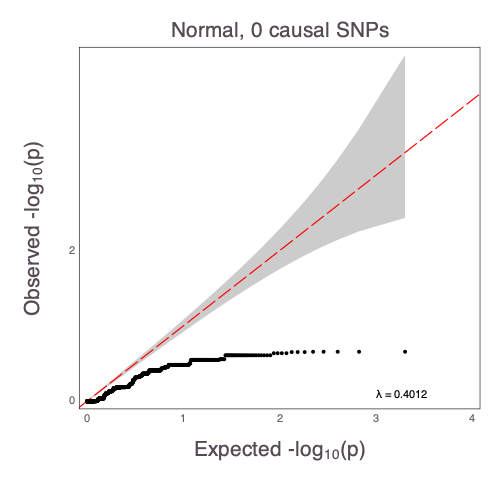

In [62]:
qq(pvals, dpi=100, titles="Normal, $k causal SNPs")
display("image/png", read("qqplot.png"))

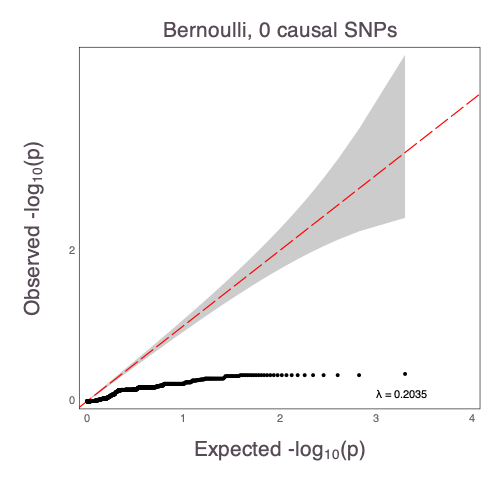

In [42]:
qq(pvals, dpi=100, titles="Bernoulli, $k causal SNPs")
display("image/png", read("qqplot.png"))

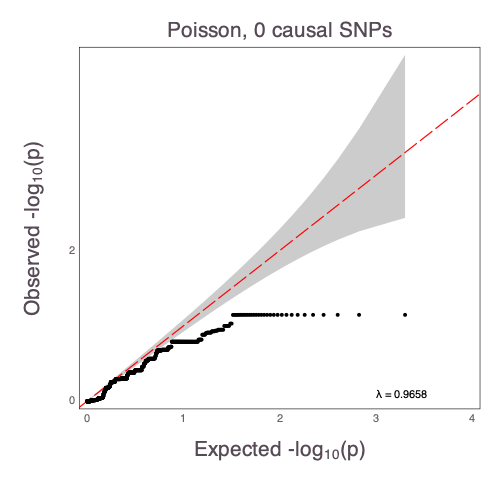

In [101]:
qq(pvals, dpi=100, titles="Poisson, $k causal SNPs")
display("image/png", read("qqplot.png"))

# Score test by autodiffing $d^2r_i(\beta)$

In [141]:
# sample data
X = qc_model.data[1].X # d by p
y = qc_model.data[1].y # d by 1

# objective
function resβ(β)
    η = X * β # d by 1
    μ = GLM.linkinv.(LogLink(), η)
    varμ = GLM.glmvar.(Poisson(), μ)
    return (y - μ) ./ sqrt.(varμ) # d by 1
end

# autodiff gradient
∇resβ_autodiff = x -> ForwardDiff.jacobian(resβ, x)

# autodiff Hessian
d²resβ_autodiff = x -> ForwardDiff.jacobian(∇resβ_autodiff, x)

#219 (generic function with 1 method)

In [142]:
∇resβ_autodiff(qc_model.β)

5×3 Matrix{Float64}:
 -0.450868   0.13916    0.107728
 -1.47034   -2.46534   -1.03208
 -0.449471   0.156035   0.0746745
 -0.495609  -0.405738   0.222716
 -0.400806   0.688395  -0.121314

In [143]:
d²resβ_autodiff(qc_model.β)

15×3 Matrix{Float64}:
 -0.225434    0.0695798   0.053864
  0.201185    0.33733     0.141218
 -0.224736    0.0780177   0.0373372
 -0.247805   -0.202869    0.111358
 -0.200403    0.344198   -0.0606569
  0.0695798  -0.0214757  -0.016625
  0.33733     0.565606    0.236782
  0.0780177  -0.0270841  -0.0129617
 -0.202869   -0.166082    0.0911649
  0.344198   -0.591169    0.10418
  0.053864   -0.016625   -0.01287
  0.141218    0.236782    0.0991255
  0.0373372  -0.0129617  -0.00620315
  0.111358    0.0911649  -0.0500417
 -0.0606569   0.10418    -0.0183593

In [ ]:
function GWASCopulaVCModel(
    gcm::Union{GLMCopulaVCModel, NBCopulaVCModel},
    G::SnpArray;
    num_Hessian_terms::Int = 3
    )
    # define autodiff likelihood, gradient, and Hessians
    autodiff_loglikelihood(β) = loglikelihood(β, gcm, z)
    ∇logl = x -> ForwardDiff.gradient(autodiff_loglikelihood, x)
    ∇²logl = x -> ForwardDiff.hessian(autodiff_loglikelihood, x)
    # some needed constants
    n, q = size(G)
    p = length(gcm.β)
    dist = _get_null_distribution(gcm)
    T = eltype(gcm.data[1].X)
    n == length(gcm.data) || error("sample size do not agree")
    any(x -> abs(x) > 1e-3, gcm.∇β) && error("Null model gradient of beta is not zero!")
    any(x -> abs(x) > 1e-3, gcm.∇θ) && error("Null model gradient of variance components is not zero!")
    # preallocated arrays for efficiency
    z = zeros(T, n)
    W = zeros(T, p)
    χ2 = Chisq(1)
    pvals = zeros(T, q)
    fullβ = [gcm.β; 0.0]
    # compute P (negative Hessian) and inv(P)
    if num_Hessian_terms == 2
        P = -two_term_Hessian(gcm)
    elseif num_Hessian_terms == 3
        P = -three_term_Hessian(gcm)
    elseif num_Hessian_terms == 4
        P = -four_term_Hessian(gcm)
    else
        error("num_Hessian_terms should be 2, 3, or 4 but was $num_Hessian_terms")
    end
    Pinv = inv(P)
    # score test for each SNP
    for j in 1:q
        # sync vectors
        SnpArrays.copyto!(z, @view(G[:, j]), center=false, scale=false, impute=false)
        full_grad = zeros(p + 1)
        Q, R = zero(T), zero(T)
        fill!(W, 0)
        # loop over each sample
        for i in 1:n
            # variables for current sample
            gc = gcm.data[i]
            d = gc.n # number of observations for current sample
            zi = fill(z[i], d)
            res = gc.res # d × 1 standardized residuals
            # update ∇resγ
            ∇resγ = zeros(T, d)
            ∇resβ = gc.∇resβ # d × p
            for k in 1:d # loop over each sample's observation
                ∇resγ[k] = update_∇resβ(dist, zi[k], res[k], gc.μ[k], gc.dμ[k], gc.varμ[k])
            end
            # calculate trailing terms (todo: efficiency)
            Γ = zeros(T, d, d)
            for k in 1:gc.m # loop over variance components
                Γ .+= gcm.θ[k] .* gc.V[k]
            end
            # denom = 1 + dot(gcm.θ, gc.q) # note dot(θ, gc.q) = qsum = 0.5 r'Γr
            denom = 1 + 0.5 * (res' * Γ * res)
            denom2 = abs2(denom)
            Wtrail = (∇resβ' * Γ * res) * (∇resγ' * Γ * res)' / denom2
            Qtrail = (∇resγ' * Γ * res) * (∇resγ' * Γ * res)' / denom2
            Rtrail = (∇resγ' * Γ * res) / denom
            # third Hessian term
            Wtrail2 = ∇resβ' * Γ * ∇resγ / denom
            Qtrail2 = ∇resγ' * Γ * ∇resγ / denom
            # 4th term via autodiff
            Wtrail3 = 
            Qtrail3 = 
            # score test variables
            W .+= Transpose(gc.X) * Diagonal(gc.w2) * zi .+ Wtrail .- Wtrail2
            Q += Transpose(zi) * Diagonal(gc.w2) * zi + Qtrail - Qtrail2
            R += Transpose(zi) * Diagonal(gc.w1) * (gc.y - gc.μ) + Rtrail
        end
        # score test (todo: efficiency)
        S = R * inv(Q - W'*Pinv*W) * R
        pval = ccdf(χ2, S)
        pvals[j] = pval == 0 ? 1 : pval
    end
    return pvals
end